In [1]:
# Parameters
survey_url = "https://suave-dev.sdsc.edu/main/file=zaslavsk_WBDH_Participants.csv"
views = "1110101"
view = "grid"
user = "zaslavsk"
csv_file = "zaslavsk_WBDH_Participants.csv"
params = "none"
dzc_file = "https://maxim.ucsd.edu/dzgen/lib-staging-uploads/063044157874ce7d5841c906fa6d8073/content.dzc"
active_object = "null"
full_notebook_url = "https://colab.research.google.com/drive/1aZCpg7UmG0nPUuRPTH2p5Nm43G0HmtQg?survey_url=https://suave-dev.sdsc.edu/main/file=zaslavsk_WBDH_Participants.csv&views=1110101&view=grid&user=zaslavsk&csv_file=zaslavsk_WBDH_Participants.csv&params=none&dzc_file=https://maxim.ucsd.edu/dzgen/lib-staging-uploads/063044157874ce7d5841c906fa6d8073/content.dzc&active_object=null"


<h1><span style="color:red">Generate Contingency Tables</span></h1>

### This notebook reads numeric and categorical variables from the survey dataset, lets users compute a contingency table from variables of interest and test for independence.

## 1. Setup

<p><span style="color:red">The code below must be uncommented and run</span></p>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf myclone
!git clone --depth 1 "https://github.com/DDDyylan/Suave_on_Colab.git" myclone
%cd /content/myclone/helpers
!git pull

Cloning into 'myclone'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 81 (delta 19), reused 56 (delta 12), pack-reused 0
Unpacking objects: 100% (81/81), 621.10 KiB | 3.29 MiB/s, done.
/content/myclone/helpers
Already up to date.


In [4]:
# common imports
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Markdown, display

import datetime
import pandas as pd    
import numpy as np
import panel as pn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

pn.extension()
def printmd(string):
    display(Markdown(string))

absolutePath = "/content/drive/MyDrive/suave/"

# local imports
import sys
sys.path.insert(1, '../../helpers')
import panel_libs as panellibs
import suave_integration as suaveint

## 2. Read the survey file

In [5]:
# read the csv file
df = panellibs.extract_data(absolutePath + csv_file)

# create a list of variable names
variables_df = pd.DataFrame({'varname':df.columns})
printmd("<b><span style='color:red'>All variables in the survey file:</span></b>")
print(variables_df.varname.values)

<b><span style='color:red'>All variables in the survey file:</span></b>

['Full Name#hidden' 'Last Name' 'First Name' 'Gender' 'Instituion'
 'Phone Number#hidden' 'Contact Title#hidden' 'EmailAddress#hidden'
 'Social Media/Personal Website#link#hidden'
 'Project Information/Links#link#hidden' 'Focus Areas' 'Specialty'
 'Example Current Project#hidden' 'Other Info' '#img' '#name' '#href'
 'Project Images#multi#hidden' 'Latitude#number#hidden'
 'Longitude#number#hidden']


## 3. Select variables from survey

In [6]:
# select number of variables for contingency table
n_row = pn.widgets.IntSlider(name='Select Number of Row Variables',start=1, end=2, value=1)
n_col = pn.widgets.IntSlider(name='Select Number of Column Variables',start=1, end=2, value=1)

pn.Column(n_row, n_col)

Column
    [0] IntSlider(end=2, name='Select Number o..., start=1, value=1)
    [1] IntSlider(end=2, name='Select Number o..., start=1, value=1)

In [7]:
# select variables from survey
row_vars = pn.widgets.MultiChoice(name='Select Row Variables for Contingency Table',
                                  value=[], options=list(df.columns), max_items=n_row.value)
col_vars = pn.widgets.MultiChoice(name='Select Column Variables for Contingency Table',
                                  value=[], options=list(df.columns), max_items=n_col.value)
pn.Row(row_vars, col_vars, height=350)

Row(height=350)
    [0] MultiChoice(max_items=1, name='Select Row Variables f..., options=['Full Name#hidden', ...])
    [1] MultiChoice(max_items=1, name='Select Column V..., options=['Full Name#hidden', ...])

## 4. Bin Numerical and Date Variables

Create custom bins for numerical and date variables, or skip to the next step.

<h3><span style="color:red">(OPTIONAL) Set custom bins for numerical variables:</span></h3>

In [8]:
# select numerical columns to bin -- **unselected columns will be automatically binned into 5 equal bins**
df = df.apply(pd.to_numeric, errors='ignore')
df = df.dropna(axis=1, how='all')
op = [i for i in list(df.columns) if '#number' in i]
binnable = pn.widgets.MultiChoice(name='Select Columns to Bin: ', options=op, height=350)
binnable

MultiChoice(height=350, name='Select Columns to Bin: ', options=['Latitude#number#hidden',...])

Traceback (most recent call last):
 File "/usr/local/lib/python3.10/dist-packages/pyviz_comms/__init__.py", line 346, in _handle_msg
 self._on_msg(msg)
 File "/usr/local/lib/python3.10/dist-packages/panel/viewable.py", line 297, in _on_msg
 patch.apply_to_document(doc, comm.id if comm else None)
 File "/usr/local/lib/python3.10/dist-packages/bokeh/protocol/messages/patch_doc.py", line 115, in apply_to_document
 invoke_with_curdoc(doc, lambda: doc.apply_json_patch(self.content, setter))
 File "/usr/local/lib/python3.10/dist-packages/bokeh/document/callbacks.py", line 408, in invoke_with_curdoc
 return f()
 File "/usr/local/lib/python3.10/dist-packages/bokeh/protocol/messages/patch_doc.py", line 115, in <lambda>
 invoke_with_curdoc(doc, lambda: doc.apply_json_patch(self.content, setter))
 File "/usr/local/lib/python3.10/dist-packages/bokeh/document/document.py", line 391, in apply_json_patch
 DocumentPatchedEvent.handle_json(self, event_json, references, setter)
 File "/usr/local/lib/python3.10/dist-packages/bokeh/document/events.py", line 259, in handle_json
 handler(doc, event_json, references, setter)
 File "/usr/local/lib/python3.10/dist-packages/bokeh/document/events.py", line 300, in _handle_json
 cb(event_json["msg_data"])
 File "/usr/local/lib/python3.10/dist-packages/bokeh/document/callbacks.py", line 355, in trigger_json_event
 model._trigger_event(event)
 File "/usr/local/lib/python3.10/dist-packages/bokeh/util/callback_manager.py", line 119, in _trigger_event
 self.document.callbacks.notify_event(cast(Model, self), event, invoke)
 File "/usr/local/lib/python3.10/dist-packages/bokeh/document/callbacks.py", line 247, in notify_event
 invoke_with_curdoc(doc, callback_invoker)
 File "/usr/local/lib/python3.10/dist-packages/bokeh/document/callbacks.py", line 408, in invoke_with_curdoc
 return f()
 File "/usr/local/lib/python3.10/dist-packages/bokeh/util/callback_manager.py", line 115, in invoke
 cast(EventCallbackWithEvent, callback)(event)
 File "/usr/local/lib/python3.10/dist-packages/panel/reactive.py", line 413, in _comm_event
 state._handle_exception(e)
 File "/usr/local/lib/python3.10/dist-packages/panel/io/state.py", line 408, in _handle_exception
 raise exception
 File "/usr/local/lib/python3.10/dist-packages/panel/reactive.py", line 411, in _comm_event
 self._process_bokeh_event(doc, event)
 File "/usr/local/lib/python3.10/dist-packages/panel/reactive.py", line 348, in _process_bokeh_event
 self._process_event(event)
 File "/usr/local/lib/python3.10/dist-packages/panel/widgets/button.py", line 184, in _process_event
 self.clicks += 1
 File "/usr/local/lib/python3.10/dist-packages/param/parameterized.py", line 367, in _f
 instance_param.__set__(obj, val)
 File "/usr/local/lib/python3.10/dist-packages/param/parameterized.py", line 369, in _f
 return f(self, obj, val)
 File "/usr/local/lib/python3.10/dist-packages/param/__init__.py", line 625, in __set__
 super(Dynamic,self).__set__(obj,val)
 File "/usr/local/lib/python3.10/dist-packages/param/parameterized.py", line 369, in _f
 return f(self, obj, val)
 File "/usr/local/lib/python3.10/dist-packages/param/parameterized.py", line 1252, in __set__
 obj.param._call_watcher(watcher, event)
 File "/usr/local/lib/python3.10/dist-packages/param/parameterized.py", line 2043, in _call_watcher
 self_._execute_watcher(watcher, (event,))
 File "/usr/local/lib/python3.10/dist-packages/param/parameterized.py", line 2025, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "<ipython-input-12-1750a5517b56>", line 37, in b
 bin_range.value = (bin_range.value[1], df[selected_col].max())
 File "/usr/local/lib/python3.10/dist-packages/param/parameterized.py", line 367, in _f
 instance_param.__set__(obj, val)
 File "/usr/local/lib/python3.10/dist-packages/param/parameterized.py", line 369, in _f
 return f(self, obj, val)
 File "/usr/local/lib/python3.10/dist-packages/param/parameterized.py", line 1252, in __set__
 obj.param._call_watcher(watcher, event)
 File "/usr/local/lib/python3.

Row
    [0] Column
        [0] TextInput(disabled=True, name='Current Variable: ', value='Latitude#number#hidden')
        [1] Select(options=[1, 2, 3, 4, 5], value=1)
        [2] RangeSlider(end=54.0103942, name='Select Range for Bin #1', start=-6.238777, step=2, value=(-6.238777, 54.0103942), value_end=54.0103942, value_start=-6.238777)
        [3] Button(button_type='primary', name='Next Bin')
        [4] Markdown(str)
    [1] Matplotlib(Figure, dpi=80, height=192, width=256)
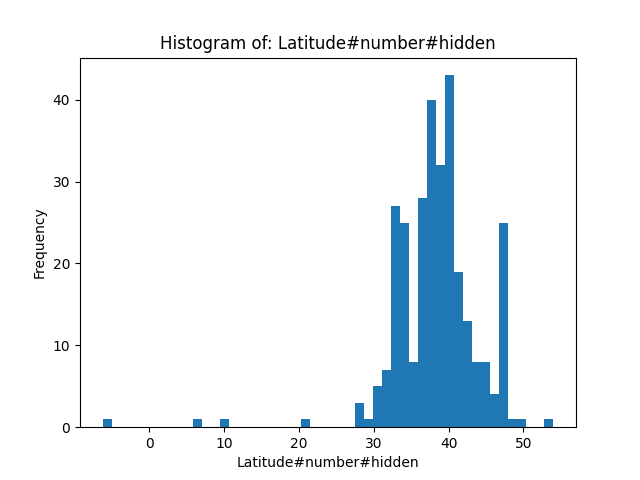

In [12]:
# set custom bins for a numeric (#number) variable
next_var = pn.widgets.Button(name='Continue to Next Variable', button_type='success')
first_col = binnable.value[next_var.clicks]
selected_bins = [[] for i in binnable.value]

text = pn.widgets.TextInput(name='Current Variable: ', value=first_col, disabled=True)
num = pn.widgets.Select(name='Select number of bins', options=[i+1 for i in range(5)])
next_bin = pn.widgets.Button(name='Next Bin', button_type='primary')
bin_range = pn.widgets.RangeSlider(name='Select Range for Bin #1',
                                   start=df[first_col].min(), end=df[first_col].max(),
                                   value=(df[first_col].min(), df[first_col].max()), step=2)

def plot_histogram(df, column, plotting_pane, x_range=None):
    """
    Helper function to plot histogram of a numeric variable
    in the provided x_range onto the panel plotting pane.
    """
    fig, ax = plt.subplots(1,1)
    df[column].plot.hist(bins=50, ax=ax, title = 'Histogram of: ' + column, xlim=x_range)
    ax.set_xlabel(column)
    plotting_pane.object = fig
    plt.close()

def b(event):
    """
    Updates bin sliders when "next" is clicked
    """
    if next_bin.clicks == 0:
        return
    
    selected_col = binnable.value[next_var.clicks]

    if next_bin.clicks < num.value:
        bin_range.name = 'Select Range for Bin #' + str(next_bin.clicks + 1)
        selected_bins[next_var.clicks].append(bin_range.value)
        bin_range.start = bin_range.value[1]
        bin_range.value = (bin_range.value[1], df[selected_col].max())
        plot_histogram(df, selected_col, plot, x_range = bin_range.value)
    else:
        selected_bins[next_var.clicks].append(bin_range.value)
        next_bin.disabled = True
        
        if selected_col != binnable.value[-1]:
            layout[0][4] = next_var
        else:
            layout[0][4] = "Variable Binning Complete!"

def c(event):
    """
    Resets layout when "continue" is clicked
    """
    next_bin.clicks = 0
    next_col = binnable.value[next_var.clicks] 
    text.value = next_col
    num.value = 1
    bin_range.start = df[next_col].min()
    bin_range.end = df[next_col].max()
    bin_range.value = (df[next_col].min(), df[next_col].max())
    next_bin.disabled = False
    layout[0][4] = ""
    plot_histogram(df, next_col, plot)

next_bin.on_click(b)
next_var.on_click(c)
plot =  pn.pane.Matplotlib(dpi=80)
plot_histogram(df, binnable.value[next_var.clicks], plot)
layout = pn.Row(pn.Column(text, num, bin_range, next_bin, ""), plot)
layout

In [13]:
# bin each column with chosen bins
cols = binnable.value
for col, bins in list(zip(cols, selected_bins)):
    bins = pd.IntervalIndex.from_tuples(bins, closed='left')
    df[col] = pd.cut(df[col], bins)
    
# bin remaining numeric columns into 5 equal bins
remainder = list(set(binnable.options) - set(binnable.value))
df[remainder] = df[remainder].apply(pd.cut, bins=5)

TypeError: ignored

<h3><span style="color:red">(OPTIONAL) Set custom bins for date variables:</span></h3>

In [11]:
# convert date variables in survey
dates = [i for i in list(df.columns) if '#date' in i]
df[dates] = df[dates].apply(pd.to_datetime, errors='coerce')
df[dates] = df[dates].apply(lambda x: x.dt.date)
d_max = pd.Series(df[dates].to_numpy().flatten()).dropna().max()
d_min = pd.Series(df[dates].to_numpy().flatten()).dropna().min()

# define bins for all date variables
date_bins = []
date_slider = pn.widgets.DateRangeSlider(name='Date Range for Bin #1 ', start=d_min, end=d_max, value=(d_min,d_max))
next_bin2 = pn.widgets.Button(name='Next Bin', button_type='primary')
num = pn.widgets.Select(name='Select number of bins', options=[i+1 for i in range(5)])

def d(event):
    """
    Updates bin sliders when "next" is clicked
    """
    if next_bin2.clicks < num.value:
        date_slider.name = 'Date Range for Bin #' + str(next_bin2.clicks + 1)
        date_bins.append(date_slider.value)
        date_slider.start = date_slider.value[1]
        date_slider.value = (date_slider.value[1], datetime.datetime(d_max.year, d_max.month, d_max.day))
        plot_dates(df, plot)
    else:
        date_bins.append(date_slider.value)
        next_bin2.disabled = True
        layout2[0][3] = 'Date Binning Complete!'
        
def plot_dates(df, plotting_pane):
    """
    Plots dates based on slider selection to the plotting pane.
    """
    all_dates = pd.DataFrame(df[dates].to_numpy().flatten(), columns=['date'])
    filtered = all_dates[(all_dates['date'] >= pd.Timestamp(date_slider.value[0]))]
    if len(filtered) == 0:
        fig, ax = fig, ax = plt.subplots(1,1)
        all_dates.groupby('date').size().plot(kind='bar', ax=ax)
        num = 20
    else:
        fig, ax = fig, ax = plt.subplots(1,1)
        filtered.groupby('date').size().plot(kind='bar', ax=ax)
        if len(filtered.groupby('date').size()) > 20:
            num = int(len(filtered.groupby('date').size())/15)
        else:
            num = 1
    ax.set_xticks(ax.get_xticks()[::num])
    ax.set_ylabel('Frequency');
    for tick in ax.get_xticklabels():
        tick.set_rotation(70)
    plotting_pane.object = fig
    plt.close()

next_bin2.on_click(d)
plot =  pn.pane.Matplotlib(dpi=80, tight=True)
plot_dates(df, plot)
layout2 = pn.Row(pn.Column(num, date_slider, next_bin2, ""), plot)
layout2

ValueError: ignored

In [ ]:
# convert selected bins to binning intervals
bins = pd.interval_range(start=pd.Timestamp(datetime.date(date_bins[0][0].year, date_bins[0][0].month, date_bins[0][0].day)),
                         end=pd.Timestamp(datetime.date(date_bins[0][1].year, date_bins[0][1].month, date_bins[0][1].day)),
                         periods=1)

for d_bin in date_bins[1:]:
    out = (datetime.date(d_bin[0].year, d_bin[0].month, d_bin[0].day),
           datetime.date(d_bin[1].year, d_bin[1].month, d_bin[1].day))
    interval = pd.interval_range(start=pd.Timestamp(out[0]), end=pd.Timestamp(out[1]), periods=1)
    bins = bins.append(interval)
    
# convert dates to date ranges
for d in dates:
    df[d] = df[d].apply(pd.Timestamp)
    df[d] = pd.cut(df[d], bins=bins)

## 4. Generate contingency table

In [ ]:
def generate_table(df, row_variables, column_variables):
    """
    Helper function to generate a contingency table from the input dataframe
    with a given list of row_variables and column_variables.
    """
    tab = pd.crosstab([df[row_variables[i]] for i in range(len(row_variables))],
                      [df[column_variables[i]] for i in range(len(column_variables))])
    table = sm.stats.Table(tab)
    return table.table_orig, table

In [ ]:
# generate contingency table
df['freq'] = 1
selected_row_vars = row_vars.value
selected_col_vars = col_vars.value
tab = generate_table(df, selected_row_vars, selected_col_vars)
tab[0]

In [ ]:
# denote shape of contingency table as two-way, three-way, or multi-way
table_shape = None
total_vars = len(row_vars.value + col_vars.value)
if total_vars == 2:
    table_shape = 'two-way'
elif total_vars == 3:
    table_shape = 'three-way'
else:
    table_shape = 'multi-way'
table_shape

## 5. Test for mutual independence

For one-way tables conduct a chi-square test of independence, under the null hypothesis that the two variables of interest are independent. For three-way and multi-way tables, fit a log-linear model to test for mutual independence between all variables of interest.  

In [ ]:
def chi_square(table, alpha=.05):
    """
    Performs a chi-square test of independence in a
    two-way contingency table at the given significance level
    """
    chi2 = table.test_nominal_association()
    
    # display a warning if expected counts are < 5
    exp_freq = table.fittedvalues.to_numpy()
    if (exp_freq < 5).sum() != 0:
        print("Warning: table contains expected frequencies less than 5.")

    # display results of chi-square test
    p_val = chi2.pvalue
    if p_val < alpha:
        print("P-value: {}. Table variables are associated at significance level: {}".format(p_val.round(4), alpha))
    else:
        print("P-value: {}. Table variables are independent at significance level: {}".format(p_val.round(4), alpha))
        
        
def llm_mutual(flat_table):
    """
    Performs log-linear analysis of the flattened multi-way
    contingency table using Poisson regression for mutual independence.
    """
    # remove suave tags from column names (interferes with statsmodels api)
    df_2 = flat_table.copy()
    df_2.columns = [i.split('#')[0].replace(' ', '_') for i in flat_table.columns]
    
    # define predictor and response variables
    predictors = (' + ').join([i.split('#')[0].replace(' ', '_') for i in row_vars.value + col_vars.value])
    response = 'freq'
    
    # fit model
    glm = smf.glm(response + ' ~ ' + predictors, data=df_2, family=sm.families.Poisson())
    res_o = glm.fit()
    print(res_o.summary())
    return res_o

In [ ]:
# perform chi-square test of independence for two-way tables
if table_shape == 'two-way':
    result = chi_square(tab[1])
# perform log-linear analysis for three-way and multi-way tables
else:
    flat = df.groupby(col_vars.value + row_vars.value).sum()['freq'].to_frame().reset_index()
    result = llm_mutual(flat)
result

<h2><span style="color:red">5a. Optional: Test for joint independence</span></h2>

<span style="color:red">The following log-linear models are for testing THREE-WAY tables only!</span> 

For three-way tables, test variables for joint-independence. The log-linear model tests for joint independence under the assumption that a single variable of interest is independent of the other two. The model implies that other two variables can have an arbitrary association, and that this association doesn't depend on the level of the variable of interest.

In [ ]:
# select a variable to test for joint indpendence
selector = pn.widgets.Select(name='Test joint indpedence of: ', options=col_vars.value + row_vars.value)
selector

In [ ]:
def llm_joint(flat_table):
    """
    Performs log-linear analysis of the flattened multi-way
    contingency table using Poisson regression for joint independence.
    """
    # remove suave tags from column names (interferes with statsmodels api)
    df_2 = flat_table.copy()
    df_2.columns = [i.split('#')[0].replace(' ', '_') for i in flat_table.columns]
    
    # define predictor and response variables
    var = row_vars.value + col_vars.value
    var.remove(selector.value)
    selected_var = selector.value.split('#')[0].replace(' ', '_')
    predictors = [i.split('#')[0].replace(' ', '_') for i in var]
    formula = 'freq ~ ' + selected_var + ' + ' + predictors[0] + ' + ' + predictors[1] + ' + ' + \
                predictors[0] + ' * ' + predictors[1]
    print('Model: ' + formula)
    
    # fit model
    glm = smf.glm(formula, data=df_2, family=sm.families.Poisson())
    res_o = glm.fit()
    return res_o

In [ ]:
if table_shape == 'three-way':
    flat = df.groupby(col_vars.value + row_vars.value).sum()['freq'].to_frame().reset_index()
    result = llm_joint(flat)
result.summary()

<h2><span style="color:red">5b. Optional: Test for conditional independence</span></h2>

For three-way tables, test variables for conditional independence. The log-linear model tests for conditional indpendence under the asumption that two variables are independent, given the third.

In [ ]:
# select a variable to condition the independence of the remaining variables
selector = pn.widgets.Select(name='Test if variables are indepndent given: ', options=col_vars.value + row_vars.value)
selector

In [ ]:
def llm_conditional(flat_table):
    """
    Performs log-linear analysis of the flattened multi-way
    contingency table using Poisson regression for conditional independence.
    """
    # remove suave tags from column names (interferes with statsmodels api)
    df_2 = flat_table.copy()
    df_2.columns = [i.split('#')[0].replace(' ', '_') for i in flat_table.columns]
    
    # define predictor and response variables
    var = row_vars.value + col_vars.value
    var.remove(selector.value)
    selected_var = selector.value.split('#')[0].replace(' ', '_')
    predictors = [i.split('#')[0].replace(' ', '_') for i in var]
    formula = 'freq ~ ' + selected_var + ' + ' + predictors[0] + ' + ' + predictors[1] + ' + ' + \
                predictors[0] + ' * ' + selected_var + '+ ' + predictors[1] +  ' * ' + selected_var
    print('Model: ' + formula)
    
    # fit model
    glm = smf.glm(formula, data=df_2, family=sm.families.Poisson())
    res_o = glm.fit()
    return res_o

In [ ]:
if table_shape == 'three-way':
    flat = df.groupby(col_vars.value + row_vars.value).sum()['freq'].to_frame().reset_index()
    result = llm_conditional(flat)
result.summary()

<h2><span style="color:red">5c. Optional: Test for homogeneous association</span></h2>

For three-way tables, test for homogeneous association between the variables. The log-linear model, or no three-factor interaction model, tests for homogeneous association and implies that the conditional reelationship between any pair of variables given the third is the same at each level of the third variable.

In [ ]:
def llm_association(flat_table):
    """
    Performs log-linear analysis of the flattened multi-way
    contingency table using Poisson regression for homogeneous association.
    """
    # remove suave tags from column names (interferes with statsmodels api)
    df_2 = flat_table.copy()
    df_2.columns = [i.split('#')[0].replace(' ', '_') for i in flat_table.columns]
    
    # define predictor and response variables
    predictors = (' + ').join([i.split('#')[0].replace(' ', '_') for i in row_vars.value + col_vars.value])
    formula = 'freq ~ (' + predictors + ')**2'
    print('Model: ' + formula)
    
    # fit model
    glm = smf.glm(formula, data=df_2, family=sm.families.Poisson())
    res_o = glm.fit()
    return res_o

In [ ]:
if table_shape == 'three-way':
    flat = df.groupby(col_vars.value + row_vars.value).sum()['freq'].to_frame().reset_index()
    result = llm_association(flat)
result.summary()